# Analysis of hand drawn maps

This script is for analysing hand drawn maps of the Willunga sub-basin based on manual water table mapping exercise and survey.

Rasters are made in ArcGis using the hand drawn contour data and converting it to a raster using "Topo2Raster" tool

Script is run in the `conda activate geo_env` enviroment

## Import packages

In [1]:
from __future__ import division

#import affine
#import contextily
import fiona
import geopandas as gpd
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import FormatStrFormatter
import os
import numpy as np
import pyproj
import pandas as pd

import rasterio 
from rasterio.crs import CRS
from rasterio.enums import Resampling
from rasterio.features import rasterize
import rasterio.mask
from rasterio.plot import show
from rasterio.transform import from_bounds
from rasterio import shutil as rio_shutil
from rasterio.vrt import WarpedVRT
from rasterio import Affine

from requests import Request
from scipy.interpolate import interpn
from scipy.interpolate import griddata
from scipy import stats
import sys
import shapely
from shapely.geometry import Point
from shapely.geometry import mapping, Polygon
import string
from owslib.wcs import WebCoverageService



%matplotlib inline

In [275]:
figuredirectory = r'C:\Users\mar886\WaterTableProject\Willunga\hand_output_rasters\figures'

## Define functions

#### Pull in the raster files - function

In [2]:
def get_raster(raster_fname):

    wt_rstr = rasterio.open(raster_fname)

    with rasterio.open(raster_fname) as grd:
        wt_ar = grd.read()[0,:,:]
        wt_meta = grd.profile   
        wt_bounds = grd.bounds
        wt_res = grd.res

    mask = np.zeros_like(wt_ar)
    nrows,ncols = np.shape(mask)

    return wt_rstr, wt_ar, wt_meta, wt_bounds, wt_res, mask, nrows, ncols

#### Change raster to utm and save in new folder - function

In [3]:
def reproject_raster(in_path, out_path, dst_crs):

    """
    """
    # reproject raster to project crs
    with rasterio.open(in_path) as src:
        src_crs = src.crs
        transform, width, height = rasterio.warp.calculate_default_transform(src_crs, dst_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()

        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height})

        with rasterio.open(out_path, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                rasterio.warp.reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)
    return(out_path)

#### Get the well indices for the raster at every well location 

In [4]:
def get_well_ixs(df_head_at_wells_from_rstr, ncols_utm, nrows_utm, wt_meta_utm, wells_df_2_gdf):
    
    ## Get the centroid locations for every pixel
    cols, rows = np.meshgrid(np.arange(ncols_utm), np.arange(nrows_utm))
    xs, ys = rasterio.transform.xy(wt_meta_utm['transform'], rows, cols)
    X_array = np.array(xs)
    Y_array = np.array(ys)
    
    ## Calculate the distance from each well to every cell in order to get the well indexes
    well_ixs = []

    for ix in df_head_at_wells_from_rstr.index:

        e_well = wells_df_2_gdf.loc[ix, "mga_easting"]
        n_well = wells_df_2_gdf.loc[ix, "mga_northing"]

        c = np.sqrt((Y_array - n_well)**2 + (X_array - e_well)**2)
        well_ixs.append(np.unravel_index(np.argmin(c, axis=None), c.shape))
    
    return well_ixs

#### Get the head results for the raster

In [5]:
def get_raster_head_per_well(well_ixs, wt_ar_utm): 
    
    raster_head_vals = []

    for ix in well_ixs:
        raster_head_vals.append(wt_ar_utm[ix[0], ix[1]])
        
    return raster_head_vals

## Projection and colour set ups

In [6]:
wgs84 = pyproj.CRS('epsg:4326')
utm   = pyproj.CRS('epsg:32754')
gda94 = pyproj.CRS('epsg:4283')
austalbers = pyproj.CRS('epsg:3577')

wt_cmap = "coolwarm"
dem_cmap = "terrain"

## Pull in the well data


In [7]:
outputdatapath = r'C:\Users\mar886\WaterTableProject\Willunga\willunga_wt\output_data'

# In this dataframe are the original data
wells_df_1 = pd.read_csv(os.path.join(outputdatapath, "well_summary_gdf_ss_a1.csv"))

# In this dataframe I have added three new measurements BUT I have also removed some rswl values
wells_df_2 = pd.read_csv(os.path.join(outputdatapath, "well_summary_gdf_ss_c.csv"))

wells_df_1.index = wells_df_1.DHNO
wells_df_2.index = wells_df_2.DHNO

# Drop some columns to make it more manageable
wells_df_2 = wells_df_2.drop(columns=['Unit_No', 'Unit_Number', 'dh_name', 'network',
       'Obs_No', 'drillhole_class', 'water_point_type_code', 
       'Orig_drilled_depth', 'Orig_drilled_date', 
       'max_drill_date', 'late_open_depth', 'late_open_date', 'late_permit_no',
       'cased_to', 'case_min_diam',  'latest_status',
       'latest_status_date', 
       'EC', 'salinity_date', 'pH', 'pH_date', 'yield', 'yield_date',
        'long_degrees',
       'long_minutes', 'long_seconds', 'lat_degrees', 'lat_minutes',
       'lat_seconds', 'hundred', 'plan', 'parcel', 'Title', 'map_250k', 'map_100k', 'map_50k',
       'map_10k', 'map_2_5k', 'map_1k', 'water_info', 'salinity',
       'water_chemistry', 'geophys_log', 'drill_log', 'lith_log', 'geometry',
       'Datetime'])

## Make wells into geodataframe

In [8]:
# I've been fiddling around with the way to get the geometry but keep 
# getting Shapely error, not sure how to resolve but it doesn't seem to be a problem for now

geometry = []

for ix in wells_df_2.index:
    x = wells_df_2.loc[ix, "decimal_long"]
    y = wells_df_2.loc[ix, "neg_decimal_lat"]
    geometry.append(Point(x,y))

wells_df_2['geometry'] = geometry
wells_df_2_gdf = gpd.GeoDataFrame(wells_df_2, geometry='geometry', crs= 'epsg:4283')

C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


## Pull in shape file of study area extent

In [9]:
study_extent_path = os.path.join(r'C:\Users\mar886\WaterTableProject\Willunga\hand_output_rasters\study_extent', 'study_extent.shp')
study_area_shp = gpd.read_file(study_extent_path)
# Change to utm
study_area_shp_utm = study_area_shp.to_crs(utm)

## Plot the study area and wells

Text(68.02985398054291, 0.5, 'Northing')

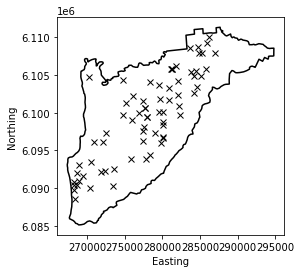

In [10]:
fig, (ax1) = plt.subplots(1, 1)
ax1.plot(wells_df_2_gdf['mga_easting'], wells_df_2_gdf['mga_northing'], "kx")
study_area_shp_utm.exterior.plot(ax=ax1, color="k", label="Study area")

plt.xlabel("Easting")
plt.ylabel("Northing")

## Check files in folder

In [11]:
fldr = r'C:\Users\mar886\WaterTableProject\Willunga\hand_output_rasters'

hand_output_raster_list = []
for file in os.listdir(fldr):
    if file.endswith(".tif"):
        hand_output_raster_list.append(file)
    else:
        pass
    
print(hand_output_raster_list)

['ref_001_raster.tif', 'ref_002_raster.tif', 'ref_003_raster.tif', 'ref_008_raster.tif', 'ref_009_raster.tif']


## Set up my database

In [12]:
# Results for estimated head at every well location based on the rasterised results
df_head_at_wells_from_rstr = pd.DataFrame()
estimated_rasters = []
estimated_arrays = []

meta_rs = []
bounds_rs = []
res_rs = []

rstr_names = []
rstr_fnames = []

wt_crops_ars = []
wt_ar_crop_trfms = []
wt_ar_crop_metas = []

## LOOP TO PULL IN HAND DRAWN RASTER DATA

See https://rasterio.readthedocs.io/_/downloads/en/merge-crs/pdf/ for information about rasterio affine transformations, page 47 section 5.9.2 Coordinate Transformation:

`|x'|      |a b c| |x|`\
`|y'|  =   |d e f| |y|`\
`|1 |      |0 0 1| |1|`

a = width of a pixel
b = row rotation (typically zero)
c = x-coordinate of the upper-left corner of the upper-left pixel
d = column rotation (typically zero)
e = height of a pixel (typically negative)
f = y-coordinate of the of the upper-left corner of the upper-left pixel

This is also useful: https://www.perrygeo.com/python-affine-transforms.html

In [13]:
rstr_i = 0


for rstr_i in range(len(hand_output_raster_list)):

    # Put in loop but for now separate to test

    name_raster = hand_output_raster_list[rstr_i][:-11]
    raster_fname = os.path.join(r'C:\Users\mar886\WaterTableProject\Willunga\hand_output_rasters', hand_output_raster_list[rstr_i])
    print(raster_fname)
    print(name_raster)

    # Realign and save as UTM raster if I have not already done this

    in_path = raster_fname
    out_path = os.path.join(r'C:\Users\mar886\WaterTableProject\Willunga\hand_output_rasters\utm_rasters', hand_output_raster_list[rstr_i])
    dst_crs = utm

    if os.path.isfile(out_path):
        pass
    else: 
        reproject_raster(in_path, out_path, dst_crs)

    # Pull in the utm raster file 

    wt_rstr_utm, wt_ar_utm, wt_meta_utm, wt_bounds_utm, wt_res_utm, mask, nrows_utm, ncols_utm = get_raster(out_path)

    
    # Crop the rasters based on shapefile
    
    with rasterio.open(out_path) as src:
        wt_ar_crop, wt_ar_crop_transform = rasterio.mask.mask(src, study_area_shp_utm.geometry, crop=False,
                                                     nodata=np.nan)
        wt_ar_crop_meta = src.meta

    # Add these to the databases

    estimated_rasters.append(wt_rstr_utm)
    estimated_arrays.append(wt_ar_utm)
    meta_rs.append(wt_meta_utm)
    bounds_rs.append(wt_bounds_utm)
    res_rs.append(wt_res_utm)
    rstr_names.append(name_raster)    
    rstr_fnames.append(raster_fname)
    
    wt_crops_ars.append(wt_ar_crop[0,:,:])
    wt_ar_crop_trfms.append(wt_ar_crop_transform)
    wt_ar_crop_metas.append(wt_ar_crop_meta)

C:\Users\mar886\WaterTableProject\Willunga\hand_output_rasters\ref_001_raster.tif
ref_001
C:\Users\mar886\WaterTableProject\Willunga\hand_output_rasters\ref_002_raster.tif
ref_002
C:\Users\mar886\WaterTableProject\Willunga\hand_output_rasters\ref_003_raster.tif
ref_003
C:\Users\mar886\WaterTableProject\Willunga\hand_output_rasters\ref_008_raster.tif
ref_008
C:\Users\mar886\WaterTableProject\Willunga\hand_output_rasters\ref_009_raster.tif
ref_009


# Exploring the different rasters/arrays - with transforms

Because when I crop it, it removes the space around the shapefile which means that the arrays are different shapes IF crop=True, but I have set crop=False

In [15]:
print(type(wt_crops_ars[0]))
print(type(estimated_arrays[0]))
print("***")

print(np.shape(wt_crops_ars[0]))
print(np.shape(estimated_arrays[0]))
print("***")

print(wt_ar_crop_trfms[0])
print("***")

print(wt_ar_crop_metas[0])
print(meta_rs[0])
print("***")
print("But shouldn't the upper left pixel be different spot since it has been cropped off?")

print(wt_ar_crop_metas[0]['transform'])
print(wt_meta_utm['transform'])

# Info about rasterio transformation: https://rasterio.readthedocs.io/en/latest/quickstart.html

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
***
(267, 287)
(267, 287)
***
| 98.81, 0.00, 266930.50|
| 0.00,-98.81, 6111495.34|
| 0.00, 0.00, 1.00|
***
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028230607370965e+38, 'width': 287, 'height': 267, 'count': 1, 'crs': CRS.from_epsg(32754), 'transform': Affine(98.81347748669839, 0.0, 266930.5015377677,
       0.0, -98.81347748669839, 6111495.336834743)}
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028230607370965e+38, 'width': 287, 'height': 267, 'count': 1, 'crs': CRS.from_epsg(32754), 'transform': Affine(98.81347748669839, 0.0, 266930.5015377677,
       0.0, -98.81347748669839, 6111495.336834743), 'tiled': False, 'interleave': 'band'}
***
But shouldn't the upper left pixel be different spot since it has been cropped off?
| 98.81, 0.00, 266930.50|
| 0.00,-98.81, 6111495.34|
| 0.00, 0.00, 1.00|
| 98.81, 0.00, 266930.50|
| 0.00,-98.81, 6111495.34|
| 0.00, 0.00, 1.00|


<AxesSubplot:>

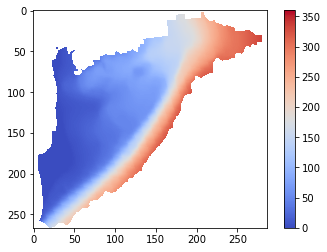

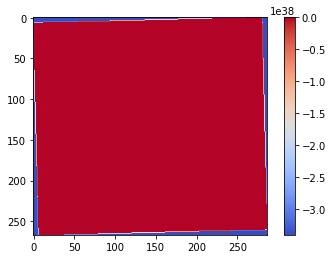

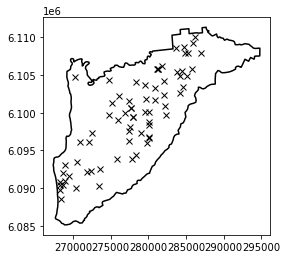

In [16]:
plt.figure()
#plt.subplot(,1,1)
img = plt.imshow(wt_crops_ars[0], vmin=0, vmax=360, cmap=wt_cmap)
plt.colorbar(img)

plt.figure()
#plt.subplot(,1,1)
img = plt.imshow(estimated_arrays[0], vmax=0, cmap=wt_cmap)
plt.colorbar(img)

fig, (ax1) = plt.subplots(1, 1)
ax1.plot(wells_df_2_gdf['mga_easting'], wells_df_2_gdf['mga_northing'], "kx")
study_area_shp_utm.exterior.plot(ax=ax1, color="k", label="Study area")


In [17]:
print(np.max(estimated_arrays[0]))
print(np.max(estimated_arrays[1]))
print(np.max(estimated_arrays[2]))
print(np.max(estimated_arrays[3]))
print(np.max(estimated_arrays[4]))

358.0
268.0
264.53348
240.0
237.51234


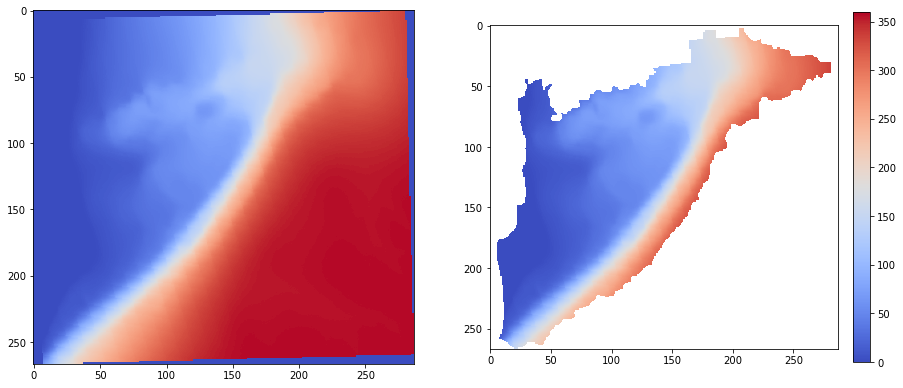

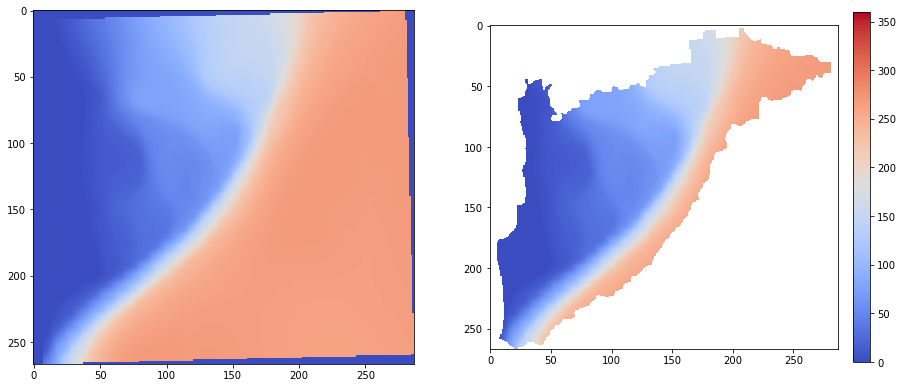

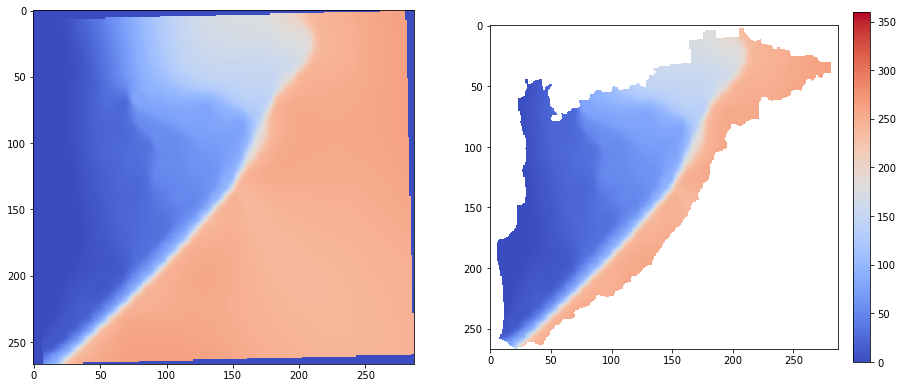

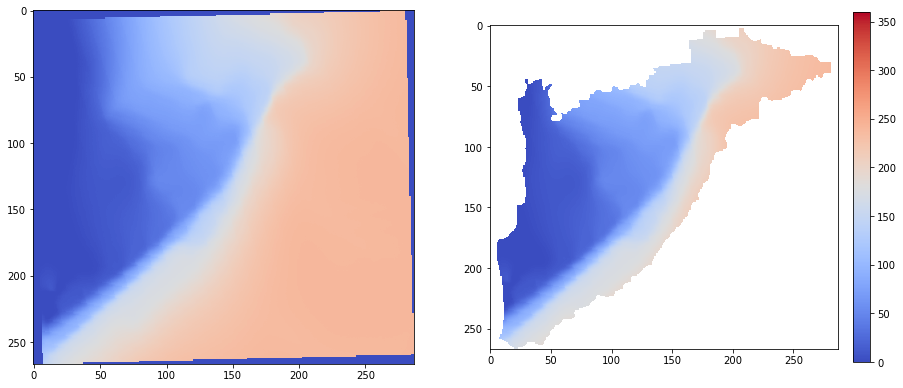

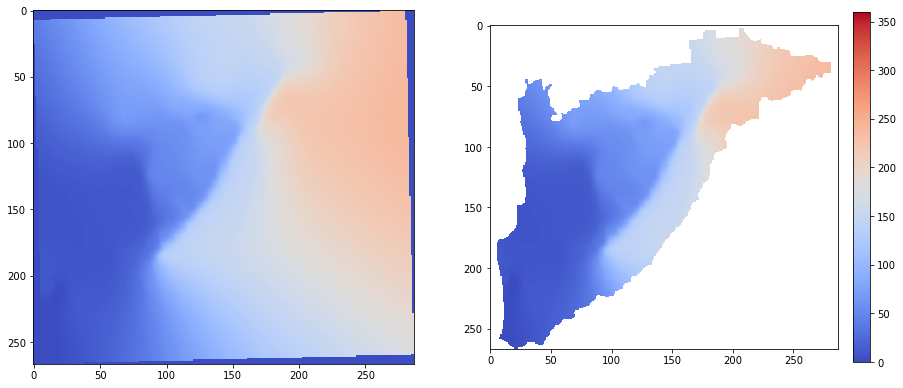

In [18]:
for i in range(len(rstr_names)):
    fig,axes = plt.subplots(1,2, figsize=(15, 15))
    img = axes[0].imshow(estimated_arrays[i], vmin=0, vmax=360, cmap=wt_cmap)
    #plt.colorbar(img, ax=axes[0], fraction=0.046, pad=0.04)

    img = axes[1].imshow(wt_crops_ars[i], vmin=0, vmax=360, cmap=wt_cmap)
    plt.colorbar(img, ax=axes[1],fraction=0.046, pad=0.04)

### Add index & rswl to my results dataframe

In [19]:
df_head_at_wells_from_rstr["DHNO"] = wells_df_2.DHNO
df_head_at_wells_from_rstr.index = df_head_at_wells_from_rstr.DHNO
df_head_at_wells_from_rstr["rswl"] = wells_df_2["rswl"]

# Need to add head value where there is a letter

In [29]:
df_head_at_wells_from_rstr.head()

,DHNO,rswl
DHNO,,
26558,26558,4.09
26565,26565,4.33
26585,26585,18.22
27050,27050,5.54
27063,27063,15.9


In [38]:
wells_df_2.head(2)

,Unnamed: 0,DHNO,Aquifer,max_drill_depth,purpose,dtw,swl,rswl,water_level_date,TDS,mga_easting,mga_northing,mga_zone,decimal_long,decimal_lat,neg_decimal_lat,dropped,new_well_locations,geometry
DHNO,,,,,,,,,,,,,,,,,,,
26558,26558,26558,Te2,340.1,OBS,18.29,18.36,4.09,8/09/2021,43438.0,268941.81,6093083.52,54.0,138.459534,35.278757,-35.278757,N,N,POINT (138.45953 -35.27876)
26565,26565,26565,Te2,105.0,INVOBS,41.70,41.30,4.33,10/09/2021,2092.0,270906.82,6096136.56,54.0,138.481972,35.251705,-35.251705,N,N,POINT (138.48197 -35.25171)


### Fix the indexes that are letters

Put the true value for those that are known and replace those that are unknown with "Unknown"

In [32]:
alphabet = string.ascii_lowercase
list_letters = []

for i in range(9):
    list_letters.append(alphabet[i])
    
wells_letter_df = wells_df_2[wells_df_2["rswl"].isin(list_letters)]

wells_df_1["DHNO"] =  wells_df_1["DHNO"].astype(str)

wells_df_1.index = wells_df_1.DHNO

news = ['new1', 'new2', 'new3', 'new4']

for ix in wells_letter_df.index:
    if ix in news:
        df_head_at_wells_from_rstr.loc[ix, "rswl"] = np.nan
    else:
#        print("start")
 #       print(ix)
        df_head_at_wells_from_rstr.loc[ix, "rswl"] = wells_df_1.loc[ix, "rswl"]

#print(df_head_at_wells_from_rstr['rswl'])

In [33]:
df_head_at_wells_from_rstr

,DHNO,rswl
DHNO,,
26558,26558,4.09
26565,26565,4.33
26585,26585,18.22
27050,27050,5.54
27063,27063,15.9
...,...,...
200678,200678,128.99
new1,new1,NaN
new2,new2,NaN


In [117]:
# Can delete later:  testing

#def get_well_ixs(df_head_at_wells_from_rstr, ncols_utm, nrows_utm, wt_meta_utm, wells_df_2_gdf):

## Get the centroid locations for every pixel
cols, rows = np.meshgrid(np.arange(ncols_utm), np.arange(nrows_utm))
xs, ys = rasterio.transform.xy(wt_meta_utm['transform'], rows, cols)
X_array = np.array(xs)
Y_array = np.array(ys)

## Calculate the distance from each well to every cell in order to get the well indexes
well_ixs = []

rswl_wells = []
e_wells = []
n_wells = []
c_vals = []
for ix in df_head_at_wells_from_rstr.index:

    e_well = wells_df_2_gdf.loc[ix, "mga_easting"]
    e_wells.append(e_well)
    n_well = wells_df_2_gdf.loc[ix, "mga_northing"]
    n_wells.append(n_well)
    rswl_wells.append(wells_df_2_gdf.loc[ix, "rswl"])

    c = np.sqrt((Y_array - n_well)**2 + (X_array - e_well)**2)
    c_vals.append(c)
    well_ixs.append(np.unravel_index(np.argmin(c, axis=None), c.shape))    

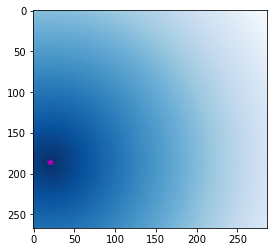

In [107]:
# Can delete: testing
len(c_vals)
len(wells_df_2_gdf)

plt.imshow(c_vals[0], cmap="Blues_r")

plt.plot(well_ixs[0][1], well_ixs[0][0], "m*")

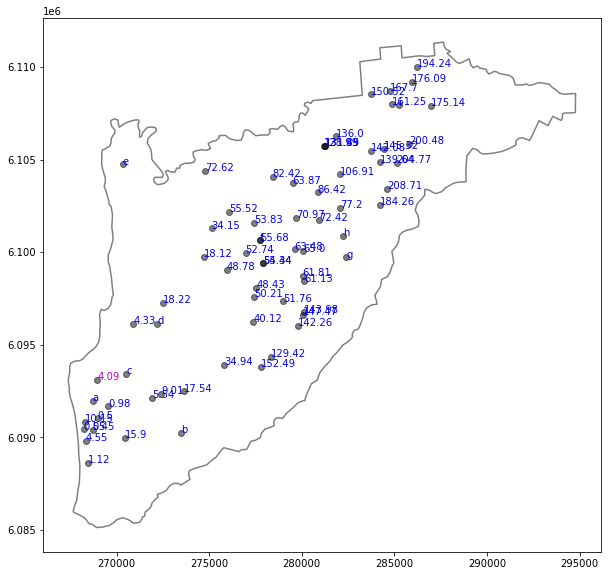

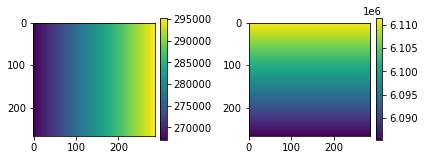

In [112]:
# Can delete: testing
# Checking it looks right

plt.figure(figsize=(10,10))
plt.plot(e_wells, n_wells, "ko", alpha=0.5)

for i in range(len(rswl_wells)):
    if i == 0:
        plt.text(e_wells[i], n_wells[i], "%s"%rswl_wells[i], c="m")
        
    else:
        plt.text(e_wells[i], n_wells[i], "%s"%rswl_wells[i], c="b")
    
ax1=plt.gca()
study_area_shp_utm.exterior.plot(ax=ax1, color="0.5", label="Study area")

plt.figure()
plt.subplot(1,2,1)
plt.imshow(xs)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(1,2,2)
plt.imshow(ys)
plt.colorbar(fraction=0.046, pad=0.04)

plt.tight_layout()

## Get the raster indices for the well locations

In [119]:
well_ixs = get_well_ixs(df_head_at_wells_from_rstr, ncols_utm, nrows_utm, wt_meta_utm, wells_df_2_gdf)
df_head_at_wells_from_rstr["well_ix"] = well_ixs
df_head_at_wells_from_rstr.head()

,DHNO,rswl,well_ix,ref_001,ref_002,ref_003,ref_008,ref_009
DHNO,,,,,,,,
26558,26558,4.09,"(186, 20)",-20.203262,-18.057812,-7.563098,-1.262213,8.995111
26565,26565,4.33,"(155, 40)",1.742489,0.965118,4.902679,5.967878,8.872720
26585,26585,18.22,"(144, 56)",14.311897,15.319687,17.065609,10.868571,10.327415
27050,27050,5.54,"(195, 50)",6.538256,2.622898,9.101677,5.021411,9.544954
27063,27063,15.9,"(217, 35)",10.516420,12.784949,11.679647,13.844901,11.932571


## Get the head value from estimated rasters at each well location

In [120]:
for rstr_i in range(len(estimated_arrays)):
    
    raster_head_vals = get_raster_head_per_well(well_ixs, estimated_arrays[rstr_i])
    
    df_head_at_wells_from_rstr[rstr_names[rstr_i]] = raster_head_vals

In [121]:
df_head_at_wells_from_rstr.head()

,DHNO,rswl,well_ix,ref_001,ref_002,ref_003,ref_008,ref_009
DHNO,,,,,,,,
26558,26558,4.09,"(186, 20)",-20.203262,-18.057812,-7.563098,-1.262213,8.995111
26565,26565,4.33,"(155, 40)",1.742489,0.965118,4.902679,5.967878,8.872720
26585,26585,18.22,"(144, 56)",14.311897,15.319687,17.065609,10.868571,10.327415
27050,27050,5.54,"(195, 50)",6.538256,2.622898,9.101677,5.021411,9.544954
27063,27063,15.9,"(217, 35)",10.516420,12.784949,11.679647,13.844901,11.932571


## Plot correlation between measured rswl and estimated rswl from raster

ref_001


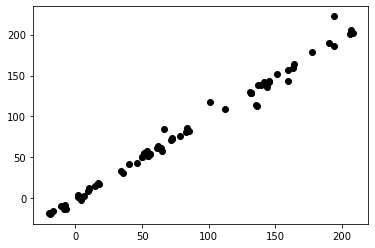

In [125]:
fig = plt.figure()
ax = plt.subplot(111)

rstr_i = 0
name_raster = rstr_names[rstr_i]
print(name_raster)

ax.plot(df_head_at_wells_from_rstr['ref_001'], df_head_at_wells_from_rstr['ref_002'], 'ko')

## Calculate cell by cell averages across all arrays

First, I need to combine all rasters into a single array, that will be the easiest way to do the statistics

In [126]:
a = wt_array_3d[0,0][0]

wt_array_3d = np.array([estimated_arrays[0], estimated_arrays[1], estimated_arrays[2], estimated_arrays[3]]) 

wt_array_3d_crop = np.array([wt_crops_ars[0], wt_crops_ars[1], wt_crops_ars[2], wt_crops_ars[3]]) 

wt_array_3d[wt_array_3d==a]=np.nan

wt_array_3d_crop[wt_array_3d_crop==a]=np.nan

In [129]:
np.shape(wt_array_3d)

max_array = np.amax(wt_array_3d, axis=0)
min_array = np.amin(wt_array_3d, axis=0)
range_array = max_array - min_array
std_array = np.std(wt_array_3d, axis=0)
mean_array = np.mean(wt_array_3d, axis=0)


max_array_crop = np.amax(wt_array_3d_crop, axis=0)
min_array_crop = np.amin(wt_array_3d_crop, axis=0)
range_array_crop = max_array - min_array
std_array_crop = np.std(wt_array_3d_crop, axis=0)
mean_array_crop = np.mean(wt_array_3d_crop, axis=0)


In [145]:
print(np.nanmax(wt_array_3d))
print(np.nanmax(wt_array_3d_crop))

115.52117
91.48259


In [150]:
print(np.nanmax(mean_array_crop))

275.45355


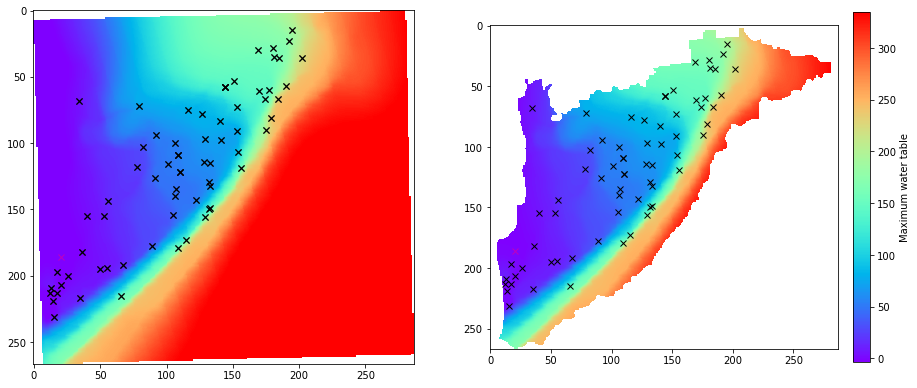

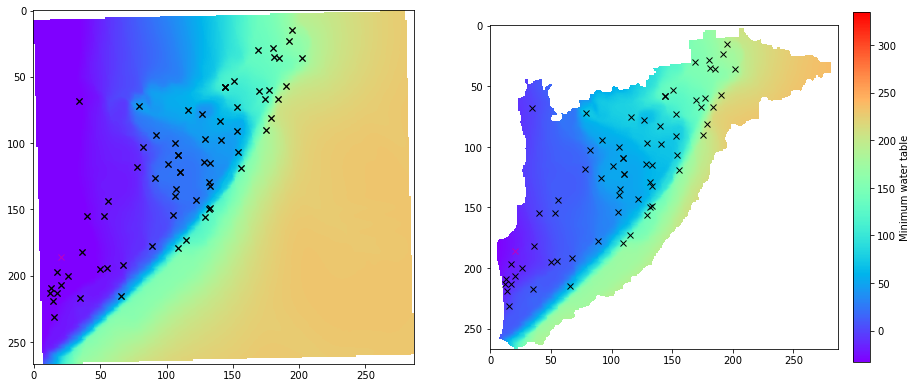

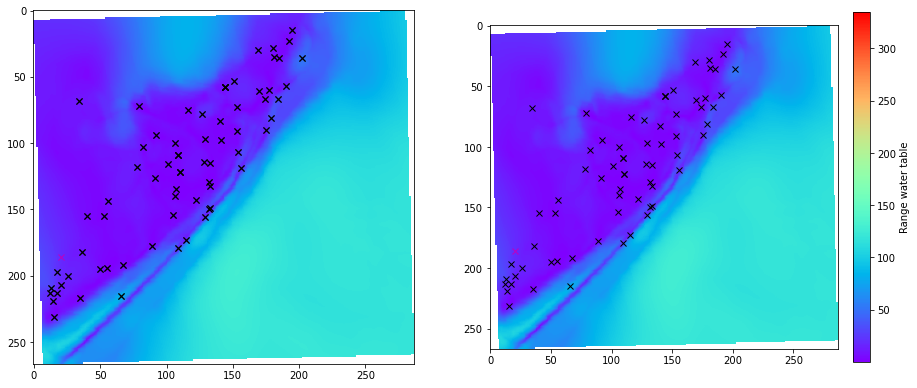

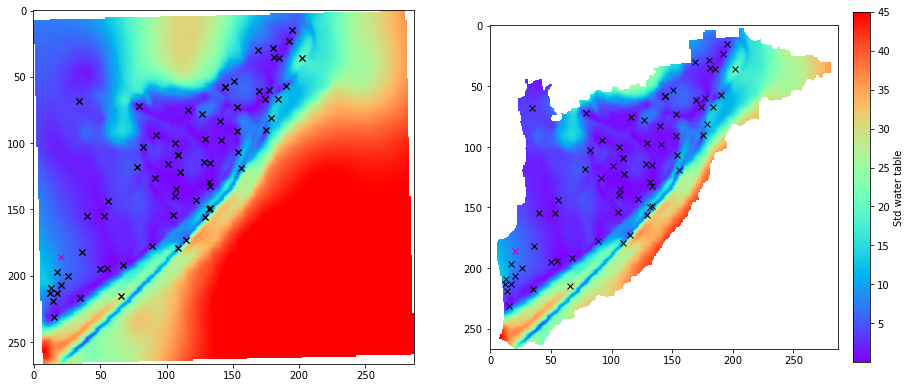

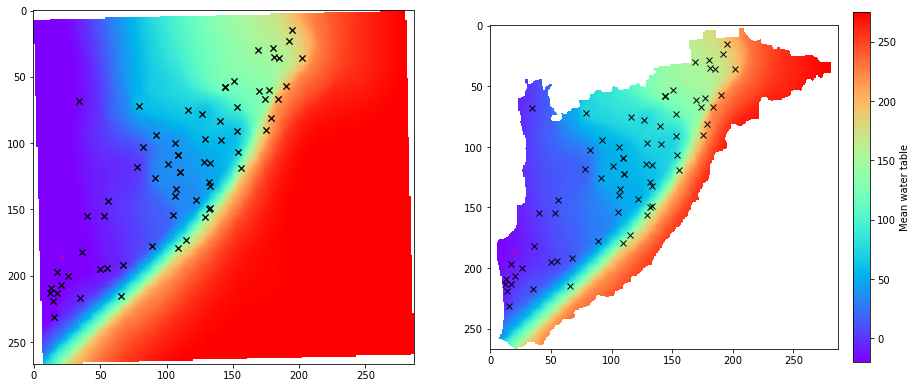

In [151]:
wt_cmap='rainbow'
# MAXIMUM

rstrs_for_plot = [max_array, max_array_crop]

fig,axes = plt.subplots(1,2, figsize=(15,15))

img = ax=axes[0].imshow(rstrs_for_plot[0], cmap=wt_cmap, vmin=0, vmax=335)

#plt.colorbar(img, ax=axes[0], label="Maximum water table",fraction=0.046, pad=0.04)

for i in range(len(well_ixs)):
    if i == 0:
        axes[0].plot(well_ixs[i][1],well_ixs[i][0], "mx")
    else:
        axes[0].plot(well_ixs[i][1],well_ixs[i][0], "kx")
        axes[0].plot(well_ixs[i][1],well_ixs[i][0], "kx")

img = ax=axes[1].imshow(rstrs_for_plot[1], cmap=wt_cmap , vmax=335)

plt.colorbar(img, ax=axes[1], label="Maximum water table",fraction=0.046, pad=0.04)

for i in range(len(well_ixs)):
    if i == 0:
        axes[1].plot(well_ixs[i][1],well_ixs[i][0], "mx")
    else:
        axes[1].plot(well_ixs[i][1],well_ixs[i][0], "kx")
        
#-------------------------------------

# MINIMUM

rstrs_for_plot = [min_array, min_array_crop]

fig,axes = plt.subplots(1,2, figsize=(15,15))

img = ax=axes[0].imshow(rstrs_for_plot[0], cmap=wt_cmap, vmin=0, vmax=335)

#plt.colorbar(img, ax=axes[0], label="Maximum water table",fraction=0.046, pad=0.04)

for i in range(len(well_ixs)):
    if i == 0:
        axes[0].plot(well_ixs[i][1],well_ixs[i][0], "mx")
    else:
        axes[0].plot(well_ixs[i][1],well_ixs[i][0], "kx")
        axes[0].plot(well_ixs[i][1],well_ixs[i][0], "kx")

img = ax=axes[1].imshow(rstrs_for_plot[1], cmap=wt_cmap , vmax=335)

plt.colorbar(img, ax=axes[1], label="Minimum water table",fraction=0.046, pad=0.04)

for i in range(len(well_ixs)):
    if i == 0:
        axes[1].plot(well_ixs[i][1],well_ixs[i][0], "mx")
    else:
        axes[1].plot(well_ixs[i][1],well_ixs[i][0], "kx")
        
        #-------------------------------------

# RANGE

rstrs_for_plot = [range_array, range_array_crop]

fig,axes = plt.subplots(1,2, figsize=(15,15))

img = ax=axes[0].imshow(rstrs_for_plot[0], cmap=wt_cmap, vmin=0, vmax=335)

#plt.colorbar(img, ax=axes[0], label="Maximum water table",fraction=0.046, pad=0.04)

for i in range(len(well_ixs)):
    if i == 0:
        axes[0].plot(well_ixs[i][1],well_ixs[i][0], "mx")
    else:
        axes[0].plot(well_ixs[i][1],well_ixs[i][0], "kx")
        axes[0].plot(well_ixs[i][1],well_ixs[i][0], "kx")

img = ax=axes[1].imshow(rstrs_for_plot[1], cmap=wt_cmap , vmax=335)

plt.colorbar(img, ax=axes[1], label="Range water table",fraction=0.046, pad=0.04)

for i in range(len(well_ixs)):
    if i == 0:
        axes[1].plot(well_ixs[i][1],well_ixs[i][0], "mx")
    else:
        axes[1].plot(well_ixs[i][1],well_ixs[i][0], "kx")
        
#-------------------------------------

        # STD

rstrs_for_plot = [std_array, std_array_crop]

fig,axes = plt.subplots(1,2, figsize=(15,15))

img = ax=axes[0].imshow(rstrs_for_plot[0], cmap=wt_cmap, vmin=0, vmax=45)

#plt.colorbar(img, ax=axes[0], label="Maximum water table",fraction=0.046, pad=0.04)

for i in range(len(well_ixs)):
    if i == 0:
        axes[0].plot(well_ixs[i][1],well_ixs[i][0], "mx")
    else:
        axes[0].plot(well_ixs[i][1],well_ixs[i][0], "kx")
        axes[0].plot(well_ixs[i][1],well_ixs[i][0], "kx")

img = ax=axes[1].imshow(rstrs_for_plot[1], cmap=wt_cmap , vmax=45)

plt.colorbar(img, ax=axes[1], label="Std water table",fraction=0.046, pad=0.04)

for i in range(len(well_ixs)):
    if i == 0:
        axes[1].plot(well_ixs[i][1],well_ixs[i][0], "mx")
    else:
        axes[1].plot(well_ixs[i][1],well_ixs[i][0], "kx")
        
        #-------------------------------------

        # MEAN

rstrs_for_plot = [mean_array, mean_array_crop]

fig,axes = plt.subplots(1,2, figsize=(15,15))

img = ax=axes[0].imshow(rstrs_for_plot[0], cmap=wt_cmap, vmin=0, vmax=275)

#plt.colorbar(img, ax=axes[0], label="Maximum water table",fraction=0.046, pad=0.04)

for i in range(len(well_ixs)):
    if i == 0:
        axes[0].plot(well_ixs[i][1],well_ixs[i][0], "mx")
    else:
        axes[0].plot(well_ixs[i][1],well_ixs[i][0], "kx")
        axes[0].plot(well_ixs[i][1],well_ixs[i][0], "kx")

img = ax=axes[1].imshow(rstrs_for_plot[1], cmap=wt_cmap , vmax=275)

plt.colorbar(img, ax=axes[1], label="Mean water table",fraction=0.046, pad=0.04)

for i in range(len(well_ixs)):
    if i == 0:
        axes[1].plot(well_ixs[i][1],well_ixs[i][0], "mx")
    else:
        axes[1].plot(well_ixs[i][1],well_ixs[i][0], "kx")

## Plots for the poster

Note that I can't get the array, wells and the colourbar all on one plot! So I'm going to have to make two and just amend the figure afterwards

### Write the arrays as rasters so I can plot them with the correct axis (then read them back in)

### First: the mean raster

In [258]:
mean_fname = os.path.join(r"C:\Users\mar886\WaterTableProject\Willunga\hand_output_rasters\summary_rasters", 
                         "mean_wt.tif")

if os.path.exists(mean_fname):
    pass
else:
    new_dataset = rasterio.open(
        mean_fname,
        'w',                                 # Writing the file (making a new raster)
        driver='GTiff',
        height=wt_ar_crop_metas[0]['height'],
        width=wt_ar_crop_metas[0]['width'],
        count=1,                                            # A count of the dataset bands
        dtype=wt_ar_crop_metas[0]['dtype'],                           # Optional
        crs=wt_ar_crop_metas[0]['crs'],                                 # Optional  
        transform=wt_ar_crop_metas[0]['transform'])                    # Optional


    new_dataset.write(mean_array_crop, 1)
    new_dataset.close()

with rasterio.open(mean_fname) as grd:
    mean_ar = grd.read()[0,:,:]
    mean_meta = grd.profile   
    
mean_rstr = rasterio.open(mean_fname)

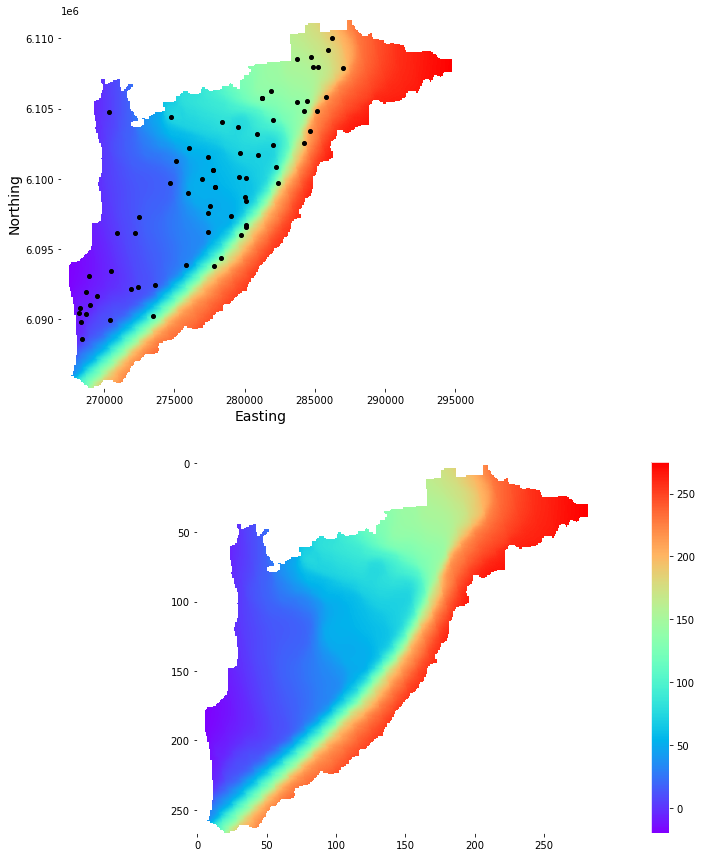

In [411]:
#-------------------------------------
plt.figure(figsize=(20,15), frameon=False)
ax1=plt.subplot(211)

image1 = show(mean_rstr, ax=ax1, cmap=wt_cmap)
ax1.plot(wells_df_2_gdf['mga_easting'], wells_df_2_gdf['mga_northing'], "ko", markersize=4)

#fig.colorbar(image_hidden, ax=ax1)

plt.xlabel("Easting", fontsize=14)
plt.ylabel("Northing", fontsize=14)

ax2=plt.subplot(212)

image_hidden = ax2.imshow(mean_array_crop, cmap=wt_cmap , vmax=275)
plt.colorbar(image_hidden)

plt.savefig(os.path.join(figuredirectory, "mean"), dpi=300)

### Second: the standard deviation raster

In [269]:
std_fname = os.path.join(r"C:\Users\mar886\WaterTableProject\Willunga\hand_output_rasters\summary_rasters", 
                         "std_wt.tif")

if os.path.exists(std_fname):
    pass
else:
    new_dataset = rasterio.open(
        std_fname,
        'w',                                 # Writing the file (making a new raster)
        driver='GTiff',
        height=wt_ar_crop_metas[0]['height'],
        width=wt_ar_crop_metas[0]['width'],
        count=1,                                            # A count of the dataset bands
        dtype=wt_ar_crop_metas[0]['dtype'],                           # Optional
        crs=wt_ar_crop_metas[0]['crs'],                                 # Optional  
        transform=wt_ar_crop_metas[0]['transform'])                    # Optional


    new_dataset.write(std_array_crop, 1)
    new_dataset.close()
    
with rasterio.open(std_fname) as grd:
    std_ar = grd.read()[0,:,:]
    std_meta = grd.profile   
    
std_rstr = rasterio.open(std_fname)

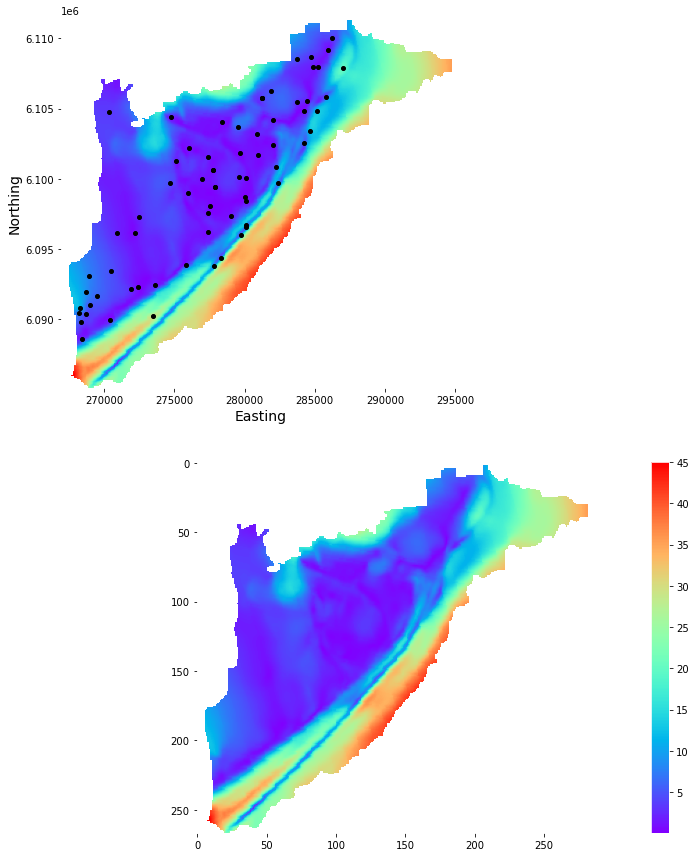

In [278]:
#-------------------------------------
plt.figure(figsize=(20,15), frameon=False)
ax1=plt.subplot(211)

image1 = show(std_rstr, ax=ax1, cmap=wt_cmap)

ax1.plot(wells_df_2_gdf['mga_easting'], wells_df_2_gdf['mga_northing'], "ko", markersize=4)

#fig.colorbar(image_hidden, ax=ax1)

plt.xlabel("Easting", fontsize=14)
plt.ylabel("Northing", fontsize=14)

ax2=plt.subplot(212)

image_hidden = ax2.imshow(std_array_crop, cmap=wt_cmap , vmax=45)
plt.colorbar(image_hidden)

plt.savefig(os.path.join(figuredirectory, "std"), dpi=300)

## Looking at variability in estimate at wells

In [354]:
df_head_at_wells_from_rstr["rswl"] = df_head_at_wells_from_rstr["rswl"].apply(pd.to_numeric, errors='raise')

In [356]:
df_head_at_wells_from_rstr.tail(2)


,DHNO,rswl,well_ix,ref_001,ref_002,ref_003,ref_008,ref_009,mean_wells,std_wells
DHNO,,,,,,,,,,
new3,new3,NaN,"(155, 53)",9.999249,11.607593,12.187277,10.535300,10.058204,10.877525,0.975733
new4,new4,NaN,"(68, 34)",4.326117,-1.677065,7.789410,3.097975,44.012310,11.509749,18.483181


### Testing if the indexes/values look right

I think they look ok

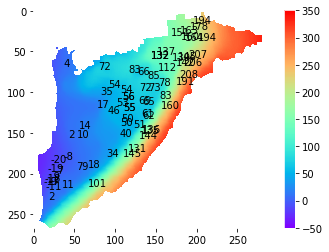

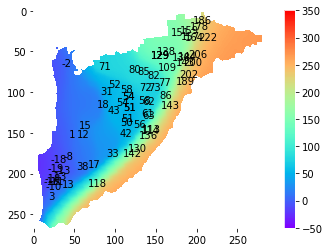

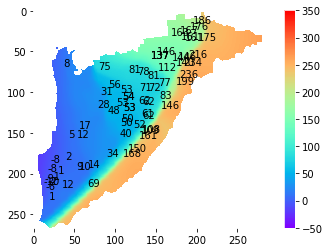

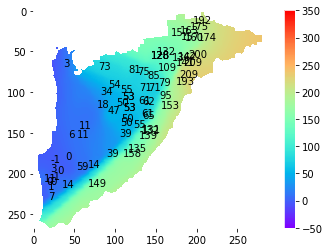

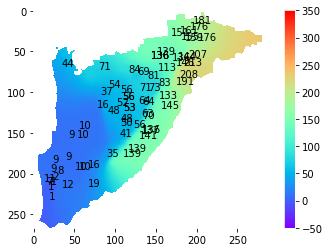

In [324]:
df_head_at_wells_from_rstr
rstr_i = 0    

for rstr_i in range(len(estimated_arrays)):
    plt.figure()
    plt.imshow(wt_crops_ars[rstr_i], cmap=wt_cmap, vmin=-50, vmax=350) #
    plt.colorbar()

    for i in range(len(well_ixs)):
        ix = well_ixs[i]
        raster_head_val = estimated_arrays[rstr_i][ix[0], ix[1]]
        plt.text(ix[1], ix[0], "%2.0f" %raster_head_val)

In [326]:
df_head_at_wells_from_rstr.head()

,DHNO,rswl,well_ix,ref_001,ref_002,ref_003,ref_008,ref_009
DHNO,,,,,,,,
26558,26558,4.09,"(186, 20)",-20.203262,-18.057812,-7.563098,-1.262213,8.995111
26565,26565,4.33,"(155, 40)",1.742489,0.965118,4.902679,5.967878,8.872720
26585,26585,18.22,"(144, 56)",14.311897,15.319687,17.065609,10.868571,10.327415
27050,27050,5.54,"(195, 50)",6.538256,2.622898,9.101677,5.021411,9.544954
27063,27063,15.9,"(217, 35)",10.516420,12.784949,11.679647,13.844901,11.932571


First I need to change data type to numeric (maybe do this earlier?)

In [329]:
df_head_at_wells_from_rstr[rstr_names].apply(pd.to_numeric)

,ref_001,ref_002,ref_003,ref_008,ref_009
DHNO,,,,,
26558,-20.203262,-18.057812,-7.563098,-1.262213,8.995111
26565,1.742489,0.965118,4.902679,5.967878,8.872720
26585,14.311897,15.319687,17.065609,10.868571,10.327415
27050,6.538256,2.622898,9.101677,5.021411,9.544954
27063,10.516420,12.784949,11.679647,13.844901,11.932571
...,...,...,...,...,...
200678,132.011780,128.824036,136.926422,127.574760,135.647949
new1,-7.708371,-8.037018,2.343328,0.018456,8.502505
new2,159.834564,143.357864,145.505524,153.021423,144.705414


In [331]:
mean_values = df_head_at_wells_from_rstr[rstr_names].mean(axis=1)
print(mean_values)

DHNO
26558      -7.618256
26565       4.490177
26585      13.578636
27050       6.565839
27063      12.151698
             ...    
200678    132.196991
new1       -0.976220
new2      149.284958
new3       10.877525
new4       11.509749
Length: 71, dtype: float32


In [332]:
df_head_at_wells_from_rstr['mean_wells'] = df_head_at_wells_from_rstr[rstr_names].mean(axis=1)
df_head_at_wells_from_rstr['std_wells'] = df_head_at_wells_from_rstr[rstr_names].std(axis=1)
df_head_at_wells_from_rstr.head()

,DHNO,rswl,well_ix,ref_001,ref_002,ref_003,ref_008,ref_009,mean_wells,std_wells
DHNO,,,,,,,,,,
26558,26558,4.09,"(186, 20)",-20.203262,-18.057812,-7.563098,-1.262213,8.995111,-7.618256,12.080697
26565,26565,4.33,"(155, 40)",1.742489,0.965118,4.902679,5.967878,8.872720,4.490177,3.222432
26585,26585,18.22,"(144, 56)",14.311897,15.319687,17.065609,10.868571,10.327415,13.578636,2.900120
27050,27050,5.54,"(195, 50)",6.538256,2.622898,9.101677,5.021411,9.544954,6.565839,2.882638
27063,27063,15.9,"(217, 35)",10.516420,12.784949,11.679647,13.844901,11.932571,12.151698,1.246287


### Plot just based on well number

Something weird happening with rswl - BECAUSE THEY ARE STRINGS!

In [ ]:
#df_head_at_wells_from_rstr.loc[wellname, "rswl"]

Text(0, 0.5, 'Head (m)')

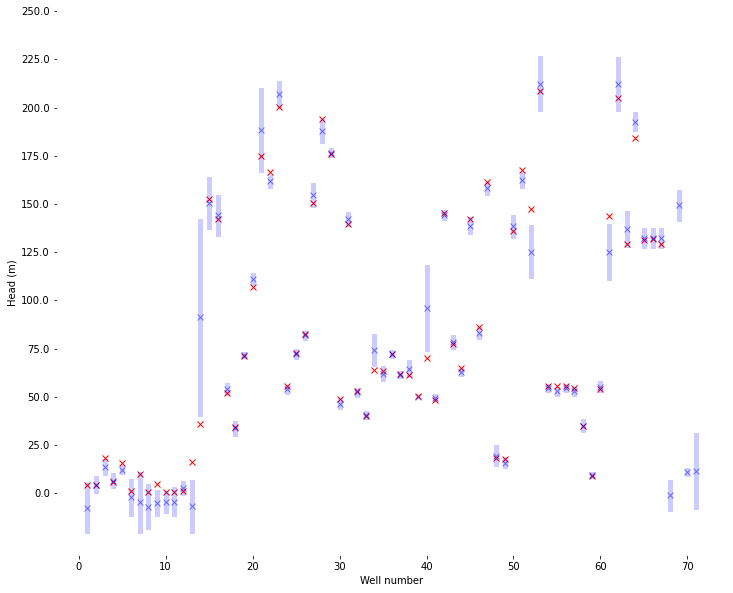

In [357]:
fig = plt.figure(figsize = (12,10))
ax = plt.gca()
rswl_val = []

xval = 1

for idx in df_head_at_wells_from_rstr.index:

    x = []
    y = []
    wellname = idx

    for i in range(len(rstr_names)):
        x.append(xval)
        y.append(df_head_at_wells_from_rstr.loc[wellname, rstr_names[i]])

    std_upper = df_head_at_wells_from_rstr.loc[wellname, "mean_wells"] +  df_head_at_wells_from_rstr.loc[wellname, "std_wells"]
    std_lower = df_head_at_wells_from_rstr.loc[wellname, "mean_wells"] -  df_head_at_wells_from_rstr.loc[wellname, "std_wells"]
    
    rswl_val.append(df_head_at_wells_from_rstr.loc[wellname, "rswl"])
    ax.plot(xval, df_head_at_wells_from_rstr.loc[wellname, "rswl"], "rx", label="Measured (m)")
    ax.plot(xval, df_head_at_wells_from_rstr.loc[wellname, "mean_wells"], "bx", alpha=0.5, label="Mean (m)")
    ax.plot([xval, xval], [std_upper,std_lower], "b-", lw=5, alpha=0.2)

    # Plotting all the data
    #ax.plot(x,y, "kx")
    
    xval += 1
    
#plt.legend()
ticks = np.linspace(0, 250, 11) 
plt.yticks(ticks=ticks, labels=ticks)
plt.xlabel("Well number")
plt.ylabel("Head (m)")

### Plot based on measured value

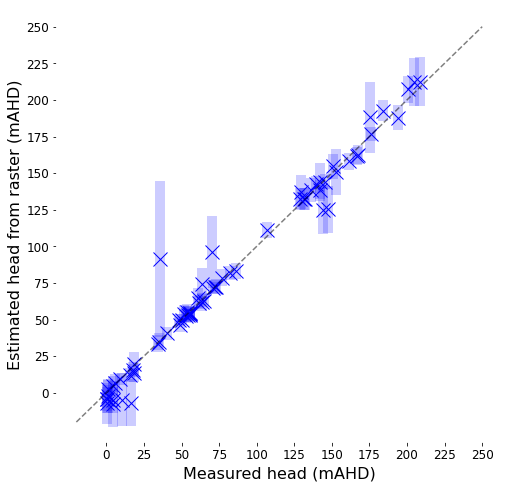

In [383]:
fig = plt.figure(figsize = (8,8))
ax = plt.gca()

for idx in df_head_at_wells_from_rstr.index:

    x = []
    y = []
    wellname = idx

    meas = df_head_at_wells_from_rstr.loc[wellname, "rswl"]
    #print("Measured head is: %s" %meas)

    
    
    for i in range(len(rstr_names)):
        x.append(meas)
        y.append(df_head_at_wells_from_rstr.loc[wellname, rstr_names[i]])

    std_upper = df_head_at_wells_from_rstr.loc[wellname, "mean_wells"] +  df_head_at_wells_from_rstr.loc[wellname, "std_wells"]
    std_lower = df_head_at_wells_from_rstr.loc[wellname, "mean_wells"] -  df_head_at_wells_from_rstr.loc[wellname, "std_wells"]

    ax.plot(meas, df_head_at_wells_from_rstr.loc[wellname, "mean_wells"], "bx", label="Mean (m)", markersize=14)
    ax.plot([meas, meas], [std_upper,std_lower], "b-", lw=10, alpha=0.2)

    # Plotting all the data
    #ax.plot(x,y, "kx")
    
    xval += 1
    
#plt.legend()
ticks = np.linspace(0, 250, 11, dtype=int) 
plt.yticks(ticks=ticks, labels=ticks, fontsize=12)
plt.xticks(ticks=ticks, labels=ticks, fontsize=12)
plt.xlabel("Measured head (mAHD)", fontsize=16)
plt.ylabel("Estimated head from raster (mAHD)", fontsize=16)

plt.plot(np.linspace(-20,250,100), np.linspace(-20,250,100), 'k--', alpha=0.5)

plt.savefig(os.path.join(figuredirectory,"rmse_allwells"), dpi=300)

## Calculate rmse

In [398]:
# First add empty column to add the values

df_head_at_wells_from_rstr["rmse"] = ""

In [408]:
import math
rmse_dict = {}
rmse = []

rstr_i

# for rstr_i in range(len(rstr_names))

for idx in df_head_at_wells_from_rstr.index:

    meas = df_head_at_wells_from_rstr.loc[idx, "rswl"]
   #print("Meas: %s"%meas)
    
    resids = []
    for rstr_i in range(len(rstr_names)):
        est = df_head_at_wells_from_rstr.loc[idx, rstr_names[rstr_i]]
        resids.append((meas-est)**2)
    resids = np.array(resids)
    
    
    rmse = math.sqrt(np.sum(resids)/len(resids))
    
    df_head_at_wells_from_rstr.loc[idx, 'rmse'] = rmse

# value of rmse across all rasters and all wells?

rmse_all = df_head_at_wells_from_rstr.sum()

rmse_total = rmse_all['rmse']/len(df_head_at_wells_from_rstr.index)

print(rmse_total)

7.066405183265352


## Plot standard deviation as a function of the well head

First change rswl to numeric

<AxesSubplot:xlabel='rswl', ylabel='mean_wells'>

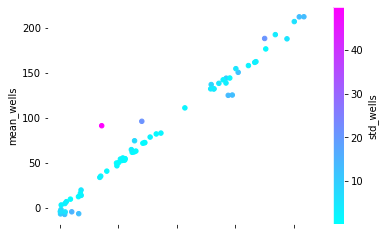

In [409]:
df_head_at_wells_from_rstr.plot.scatter(x = "rswl", y = "mean_wells", 
                                        c = "std_wells", colormap="cool")

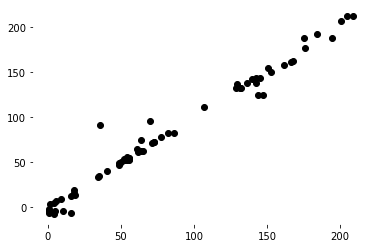

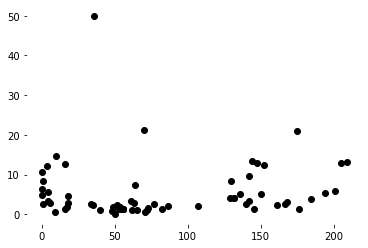

In [412]:
fig = plt.figure()
ax = plt.subplot(111)

ax.plot(df_head_at_wells_from_rstr['rswl'], df_head_at_wells_from_rstr['mean_wells'], 'ko')

fig = plt.figure()
ax = plt.subplot(111)

ax.plot(df_head_at_wells_from_rstr['rswl'], df_head_at_wells_from_rstr['std_wells'], 'ko')

## Pull in the estimated values at well locations

From the survey: https://csiroau.sharepoint.com/:x:/r/sites/PostdocSarahMarshall/Shared%20Documents/General/Willunga/manual_wt_survey.xlsx?d=wedfe971df99a444592a5e00444ba769e&csf=1&web=1&e=NyRcKW 

Save results: C:\Users\mar886\WaterTableProject\Willunga\hand_output_rasters\survey_results

** Need to save as CSV-UTF-8 data type


** I need to go through the results for the estimates and convert them to numbers, where they are a range, use the mean of that range
    

In [413]:
survey_path = os.path.join(r'C:\Users\mar886\WaterTableProject\Willunga\hand_output_rasters\survey_results', "manual_wt_survey.csv")

In [414]:
survey_results = pd.read_csv(survey_path)

In [ ]:
#survey_results.columns
#for col in range(len(survey_results.columns)):
 #   print(col)
  #  print(survey_results.columns[col])

22
Please predict the water level for point a on the map (Grid reference A8)
23
Please predict the water level for pointÊbÊon the map (Grid reference C8)
24
Please predict the water level for pointÊcÊon the map (Grid reference B7)
25
Please predict the water level for pointÊdÊon the map (Grid reference C6)
26
Please predict the water level for pointÊeÊon the map (Grid reference E5)
27
Please predict the water level for pointÊfÊon the map (Grid reference F5)
28
Please predict the water level for pointÊgÊon the map (Grid reference G5)
29
Please predict the water level for pointÊhÊon the map (Grid reference G5)
30
Please predict the water level for pointÊiÊon the map (Grid reference H2)
31
Please predict the water level for pointÊjÊon the map (Grid reference I2)

In [415]:
wt_q_idxs = [22,23,24,25,26,27,28,29,30]
wt_q_letters = ['a','b','c','d','e','f','g','h','i']

wt_q_idxs_dict = {'a': 22, 'b': 23, 'c': 24, 'd': 25, 'e': 26, 'f': 27, 'g': 28, 'h': 29, 'i': 30, 'j': 31}

In [416]:
wt_qs_df = survey_results[survey_results.columns[wt_q_idxs]]

In [417]:
# Replace nans
wt_qs_df = wt_qs_df.replace(-9999,np.nan)

print(wt_qs_df.columns)

Index(['Please predict the water level for point a on the map (Grid reference A8)',
       'Please predict the water level for pointÊbÊon the map (Grid reference C8)',
       'Please predict the water level for pointÊcÊon the map (Grid reference B7)',
       'Please predict the water level for pointÊdÊon the map (Grid reference C6)',
       'Please predict the water level for pointÊeÊon the map (Grid reference E5)',
       'Please predict the water level for pointÊfÊon the map (Grid reference F5)',
       'Please predict the water level for pointÊgÊon the map (Grid reference G5)',
       'Please predict the water level for pointÊhÊon the map (Grid reference G5)',
       'Please predict the water level for pointÊiÊon the map (Grid reference H2)'],
      dtype='object')


In [418]:
well_names_guessed = ["27125", "39875", "new1", "new3", "new4", "180822", "new2", "46232", "42108"]

wt_qs_df.columns = well_names_guessed
print(wt_qs_df)

    27125  39875  new1  new3  new4  180822   new2  46232  42108
0     5.0  100.0     7     3  54.0      63  152.0   99.0    172
1     1.0  100.0     7    12  55.0      58  150.0   90.0    170
2     3.0   50.0     6    12   8.0      54  125.0   85.0    165
3     7.0  100.0     5    10  10.0      55  150.0  110.0    165
4     1.5    5.0     4    10   4.0      54  147.0   77.0    162
5     2.0  150.0     4    12   6.0      56  150.0  100.0    162
6     5.0   65.0     5    10   4.0      54  150.0  130.0    164
7     3.0   90.0     7    11   5.0      57  135.0  110.0    164
8     5.0   30.0     5    10  10.0      55   80.0   80.0    170
9     1.0   20.0     5    15   1.0      56   75.0   73.0    160
10    5.0   50.0     5    10   2.0      56  175.0  125.0    163
11   20.0  200.0    10    50   0.0      30  200.0  200.0    225
12    1.0   10.0     5    12  30.0      55   68.0   71.0    166
13    1.0   30.0     5    13   5.0      55   92.0   88.0    164
14    1.0   22.0     5    12   1.0      

### Plot - compare estimated values to rasters

In [420]:
wt_qs_df[well_names_guessed[0]].mean()
wt_qs_df[well_names_guessed[0]].std()


18.866282349382182

In [421]:
wt_qs_df.loc[0,"27125"]

5.0

In [443]:
wells_df_2_gdf.index

Index(['26558', '26565', '26585', '27050', '27063', '27107', '27112', '27113',
       '27117', '27118', '27119', '27121', '27125', '39875', '39932', '40002',
       '40495', '40740', '40794', '42029', '42104', '42108', '42117', '42173',
       '42190', '42279', '43439', '43470', '43490', '44644', '45105', '45276',
       '45418', '45475', '46069', '46129', '46196', '46212', '46229', '46232',
       '46299', '46552', '46725', '46726', '46734', '46736', '131933',
       '142342', '156132', '166221', '166767', '166769', '177637', '179079',
       '179080', '180822', '180838', '182233', '186362', '195701', '196280',
       '196571', '196608', '196609', '200676', '200677', '200678', 'new1',
       'new2', 'new3', 'new4'],
      dtype='object', name='DHNO')

27125
39875
new1
new3
new4
180822
new2
46232
42108


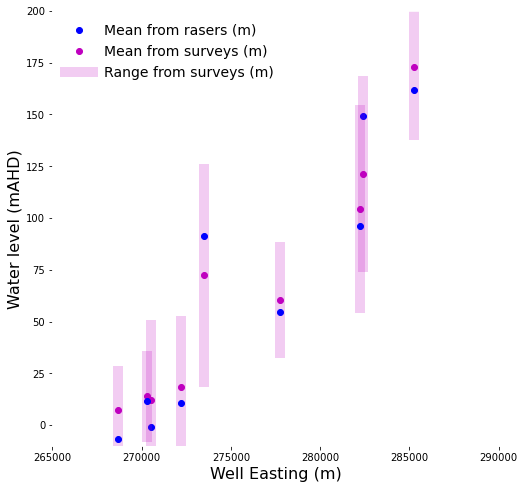

In [475]:
fig = plt.figure(figsize = (8,8))
ax = plt.gca()
offset=0

xval = 1

for idx in well_names_guessed:

    x = []
    y = []
    wellname = idx
    print(idx)
    
    for i in range(len(wt_qs_df)):
        x.append(xval)
        y.append(wt_qs_df.loc[i,idx])
        
    #xval = df_head_at_wells_from_rstr.loc[wellname, 'well_ix'][0]    
    xval = wells_df_2_gdf.loc[wellname, 'mga_easting']
    #plt.plot(x,y,"kx")
    
    # Survey results
    std_upper = wt_qs_df[idx].mean() +  wt_qs_df[idx].std()
    std_lower = wt_qs_df[idx].mean() -  wt_qs_df[idx].std()
    ax.plot([xval-1, xval-1], [std_upper,std_lower], "m-", lw=10, alpha=0.2,label='_nolegend_')

    ax.plot(xval-offset, wt_qs_df[idx].mean(), "mo", alpha=1.0, label='_nolegend_')

    # Raster results
    std_upper = df_head_at_wells_from_rstr.loc[wellname, "mean_wells"] +  df_head_at_wells_from_rstr.loc[wellname, "std_wells"]
    std_lower = df_head_at_wells_from_rstr.loc[wellname, "mean_wells"] -  df_head_at_wells_from_rstr.loc[wellname, "std_wells"]
    #ax.plot([xval+offset, xval+offset], [std_upper,std_lower], "b-", lw=10, alpha=0.2)    
    
    ax.plot(xval+offset, df_head_at_wells_from_rstr.loc[wellname, "mean_wells"], "bo", alpha=1.0, label='_nolegend_')

    
    xval += 1
    
ax.plot(-20, -20, "bo", alpha=1.0, label="Mean from rasers (m)")
ax.plot(-20, -20, "mo", alpha=1.0, label="Mean from surveys (m)")

#ax.plot([-20,-21], [-20,-21], "b-", lw=10, alpha=0.2, label="Range from rasers (m)")
ax.plot([-20,-21], [-20,-21], "m-", lw=10, alpha=0.2, label="Range from surveys (m)")

plt.legend(fontsize=14, frameon=False)

plt.xlim([265000,250000+40000])
plt.ylim([-10,200])

plt.xlabel("Well Easting (m)", fontsize=16)
plt.ylabel("Water level (mAHD)", fontsize=16)

plt.savefig(os.path.join(figuredirectory,"survey_wells"), dpi=300)

## Calculate RMSE for survey results


In [479]:
df_head_at_wells_from_rstr

,DHNO,rswl,well_ix,ref_001,ref_002,ref_003,ref_008,ref_009,mean_wells,std_wells,rmse
DHNO,,,,,,,,,,,
26558,26558,4.09,"(186, 20)",-20.203262,-18.057812,-7.563098,-1.262213,8.995111,-7.618256,12.080697,15.932289
26565,26565,4.33,"(155, 40)",1.742489,0.965118,4.902679,5.967878,8.872720,4.490177,3.222432,2.886678
26585,26585,18.22,"(144, 56)",14.311897,15.319687,17.065609,10.868571,10.327415,13.578636,2.900120,5.317031
27050,27050,5.54,"(195, 50)",6.538256,2.622898,9.101677,5.021411,9.544954,6.565839,2.882638,2.774892
27063,27063,15.90,"(217, 35)",10.516420,12.784949,11.679647,13.844901,11.932571,12.151698,1.246287,3.910544
...,...,...,...,...,...,...,...,...,...,...,...
200678,200678,128.99,"(58, 144)",132.011780,128.824036,136.926422,127.574760,135.647949,132.196991,4.094288,4.867786
new1,new1,NaN,"(182, 36)",-7.708371,-8.037018,2.343328,0.018456,8.502505,-0.976220,7.018400,NaN
new2,new2,NaN,"(119, 156)",159.834564,143.357864,145.505524,153.021423,144.705414,149.284958,6.993607,NaN


27125     float64
39875     float64
new1        int64
new3        int64
new4      float64
180822      int64
new2      float64
46232     float64
42108       int64
dtype: object

In [531]:
ix = wells_we_know[0]

meas = df_head_at_wells_from_rstr.loc[ix, 'rswl']

diff = []
for i in wt_qs_df.index:
    est = wt_qs_df.loc[i, ix]
    #print("est:%s" %(est))
    #print("est:%s" %type(est))
    diff_power_2 = ((meas-est)**2)
    #print(diff_power_2)
    diff.append(diff_power_2)
    
diff = np.array(diff)
sum = np.nansum(diff)
#print(sum)
div_sum = sum/np.count_nonzero(~np.isnan(diff))
#print(div_sum)
rmse = math.sqrt(div_sum)
print(rmse)

20.449129928063314


In [538]:
wt_qs_df.columns

wells_we_know = ['27125', '39875', '180822',  '46232', '42108']

rmse_surveys = []

for ix in wells_we_know:
    meas = df_head_at_wells_from_rstr.loc[ix, 'rswl']
    print('meas:%s'%meas)
    print("ix:%s"%ix)
    
    diff = []
    for i in wt_qs_df.index:
        est = wt_qs_df.loc[i, ix]
        #print("est:%s" %(est))
        #print("est:%s" %type(est))
        diff_power_2 = ((meas-est)**2)
        #print(diff_power_2)
        diff.append(diff_power_2)
        
    diff = np.array(diff)
    sum = np.nansum(diff)
    #print(sum)
    div_sum = sum/np.count_nonzero(~np.isnan(diff))
    #print(div_sum)
    rmse = math.sqrt(div_sum)
    print(rmse)
    rmse_surveys.append(rmse)
print(rmse_surveys)

rmse_surveys = np.array(rmse_surveys)

avr_survey_rmse= np.mean(rmse_surveys)

print("Average rmse from survey is: %s" %avr_survey_rmse)

meas:16.11
ix:27125
20.449129928063314
meas:35.77
ix:39875
62.38561699376152
meas:55.58
ix:180822
25.57708807669002
meas:70.07
ix:46232
58.03645479511292
meas:166.65
ix:42108
32.443081457881874
[20.449129928063314, 62.38561699376152, 25.57708807669002, 58.03645479511292, 32.443081457881874]
Average rmse from survey is: 39.778274250301926


##  Same plot as above but for survey results


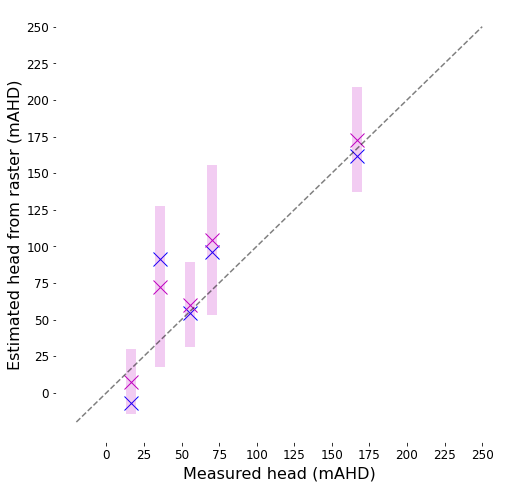

In [542]:
fig = plt.figure(figsize = (8,8))
ax = plt.gca()

for idx in wells_we_know:

    x = []
    y = []
    wellname = idx

    meas = df_head_at_wells_from_rstr.loc[wellname, "rswl"]
    #print("Measured head is: %s" %meas)

    
    
    for i in range(len(rstr_names)):
        x.append(meas)
        y.append(df_head_at_wells_from_rstr.loc[wellname, rstr_names[i]])

    std_upper = wt_qs_df[idx].mean() +  wt_qs_df[idx].std()
    std_lower = wt_qs_df[idx].mean() -  wt_qs_df[idx].std()

    ax.plot(meas, df_head_at_wells_from_rstr.loc[wellname, "mean_wells"], "bx", label="Mean (m)", markersize=14)
    ax.plot([meas, meas], [std_upper,std_lower], "m-", lw=10, alpha=0.2)
    
    ax.plot(meas, wt_qs_df[idx].mean(), "mx", markersize=14, alpha=1.0, label='_nolegend_')


    # Plotting all the data
    #ax.plot(x,y, "kx")
    
    xval += 1
    
#plt.legend()
ticks = np.linspace(0, 250, 11, dtype=int) 
plt.yticks(ticks=ticks, labels=ticks, fontsize=12)
plt.xticks(ticks=ticks, labels=ticks, fontsize=12)
plt.xlabel("Measured head (mAHD)", fontsize=16)
plt.ylabel("Estimated head from raster (mAHD)", fontsize=16)

plt.plot(np.linspace(-20,250,100), np.linspace(-20,250,100), 'k--', alpha=0.5)

plt.savefig(os.path.join(figuredirectory,"rmse_surveyprediction"), dpi=300)


In [500]:
for i in range(len(residuals)):
    print(type(residuals[i]))
    for ir in range(len(residuals[i])):
        if type(residuals[i][ir]) != 'float64':
            print(type(residuals[i][ir]))
        else:
            pass

<class 'numpy.ndarray'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.ndarray'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.fl

In [ ]:
plt.figure()

for idx in wt_qs_df.columns:
    x = df_head_at_wells_from_rstr.loc[idx, "mean_wells"]
    y = wt_qs_df[idx].mean()
    
    plt.plot(x,y,'kx')
    
plt.plot(np.linspace(-20, 200, 20), np.linspace(-20, 200, 20), '--')
plt.xlabel("Head estimated from rasters at wells")
plt.ylabel("Head estimated from eyes at wells")

plt.figure()

for idx in wt_qs_df.columns:
    x = df_head_at_wells_from_rstr.loc[idx, "rswl"]
    y = wt_qs_df[idx].mean()
    
    plt.plot(x,y,'kx')
    
plt.plot(np.linspace(-20, 200, 20), np.linspace(-20, 200, 20), '--')
plt.xlabel("Head measured from dipping at wells")
plt.ylabel("Head estimated from eyes at wells")

plt.figure()

for idx in wt_qs_df.columns:
    x = df_head_at_wells_from_rstr.loc[idx, "rswl"]
    y = df_head_at_wells_from_rstr.loc[idx, "mean_wells"]
    
    plt.plot(x,y,'kx')
    
plt.plot(np.linspace(-20, 200, 20), np.linspace(-20, 200, 20), '--')
plt.xlabel("Head measured from dipping at wells")
plt.ylabel("Head estimated from rasters at wells")

In [ ]:
# Plotting all the data
#ax.plot(x,y, "kx")
    
    
    
#plt.legend()
ticks = np.linspace(0, 250, 11) 
plt.yticks(ticks=ticks, labels=ticks)
plt.xlabel("Well number")
plt.ylabel("Head (m)")